In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
from scipy.fft import fft2, ifft2
from sklearn.metrics import mean_absolute_error as mae
import pywt

(2048, 2048)

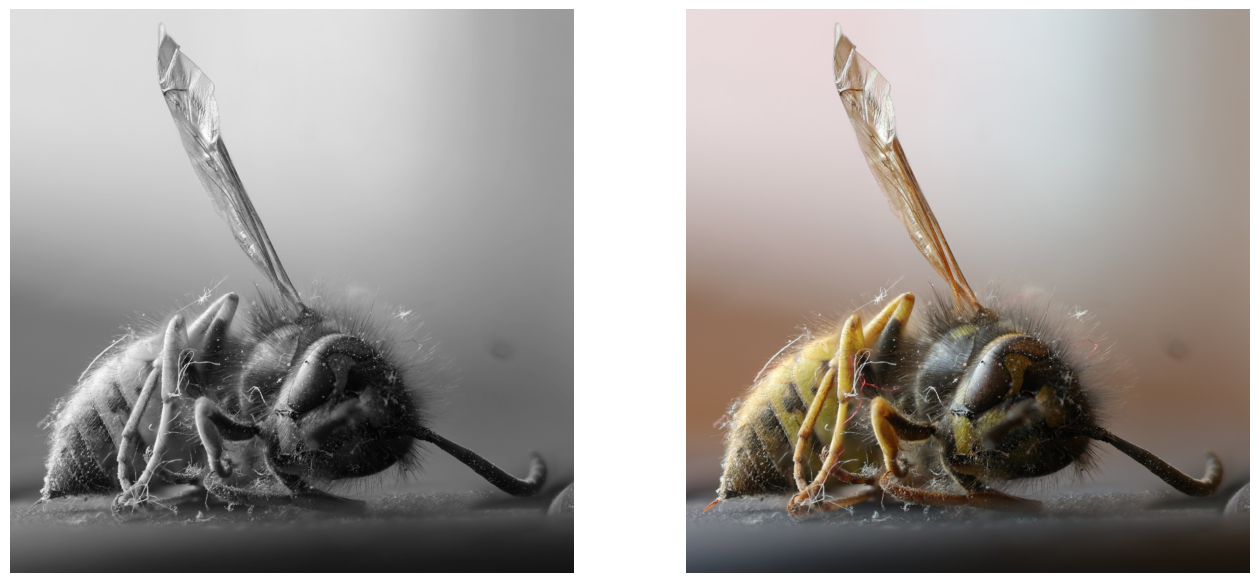

In [2]:
wasp_rgb = io.imread('wasp.png')
wasp_grayscale =  io.imread('wasp.png', as_gray=True)
#wasp_grayscale =  np.mean(wasp_rgb, -1)
plt.figure(figsize=(16, 16))

plt.subplot(1,2,1)
plt.imshow(wasp_grayscale, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wasp_rgb)
plt.axis('off')

wasp_grayscale.shape

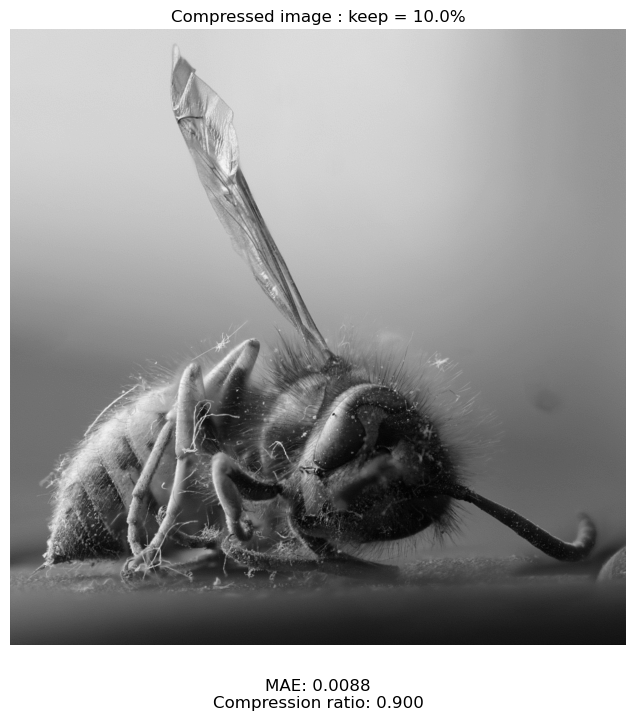

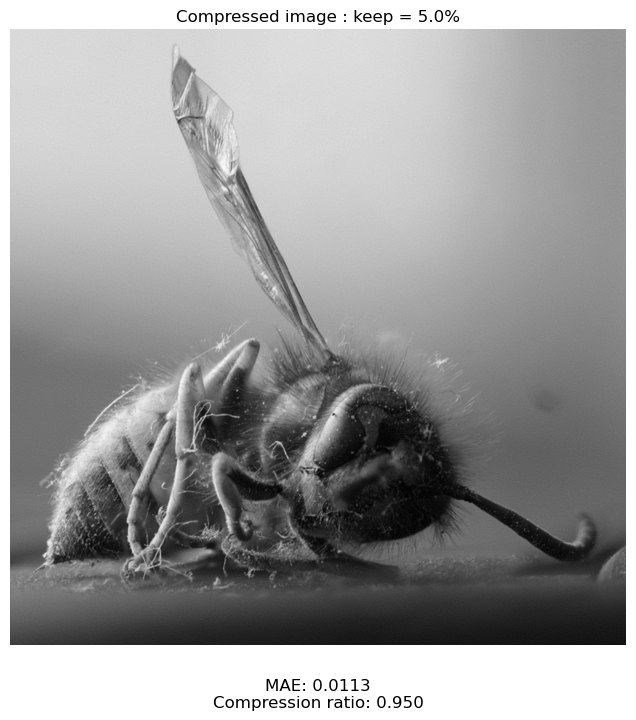

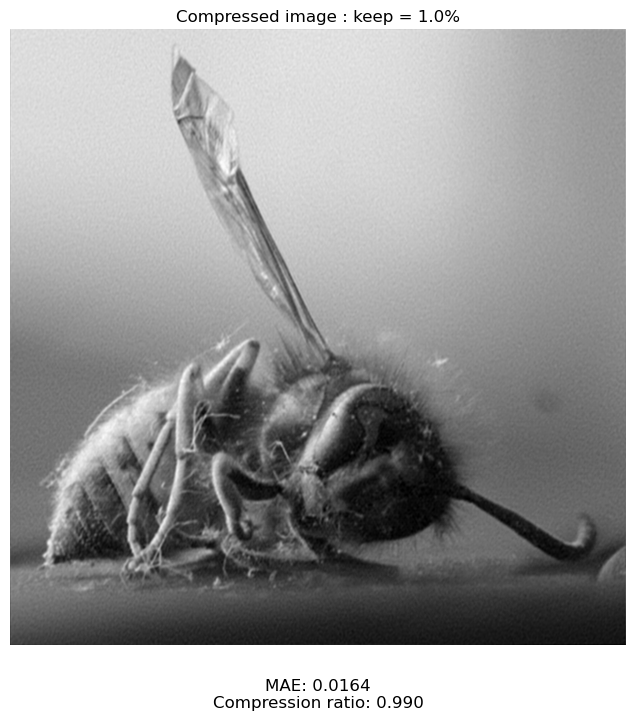

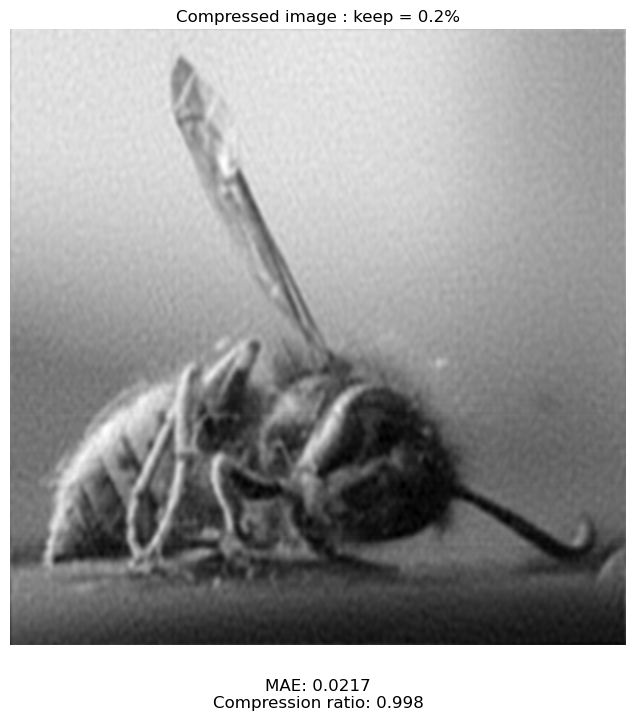

In [3]:
img_fft = fft2(wasp_grayscale)
img_fft_sorted = np.sort(np.abs(img_fft.flatten()))

for keep in (0.1, 0.05, 0.01, 0.002):
    
    thresh = img_fft_sorted[int((1-keep)*len(img_fft_sorted))]
    img_fft_thresh = img_fft * (np.abs(img_fft) > thresh)
    img_thresh = np.abs(ifft2(img_fft_thresh))
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_thresh, cmap='gray')
    plt.axis('off')
    mae_value = mae(wasp_grayscale, img_thresh)
    C = np.sum(np.abs(img_fft) <= thresh) / img_fft.size
    plt.title(f'Compressed image : keep = {keep*100}%')
    plt.text(0.5, -0.1, f"MAE: {mae_value:.4f}\nCompression ratio: {C:.3f}",fontsize=12, ha='center', transform=plt.gca().transAxes)
    


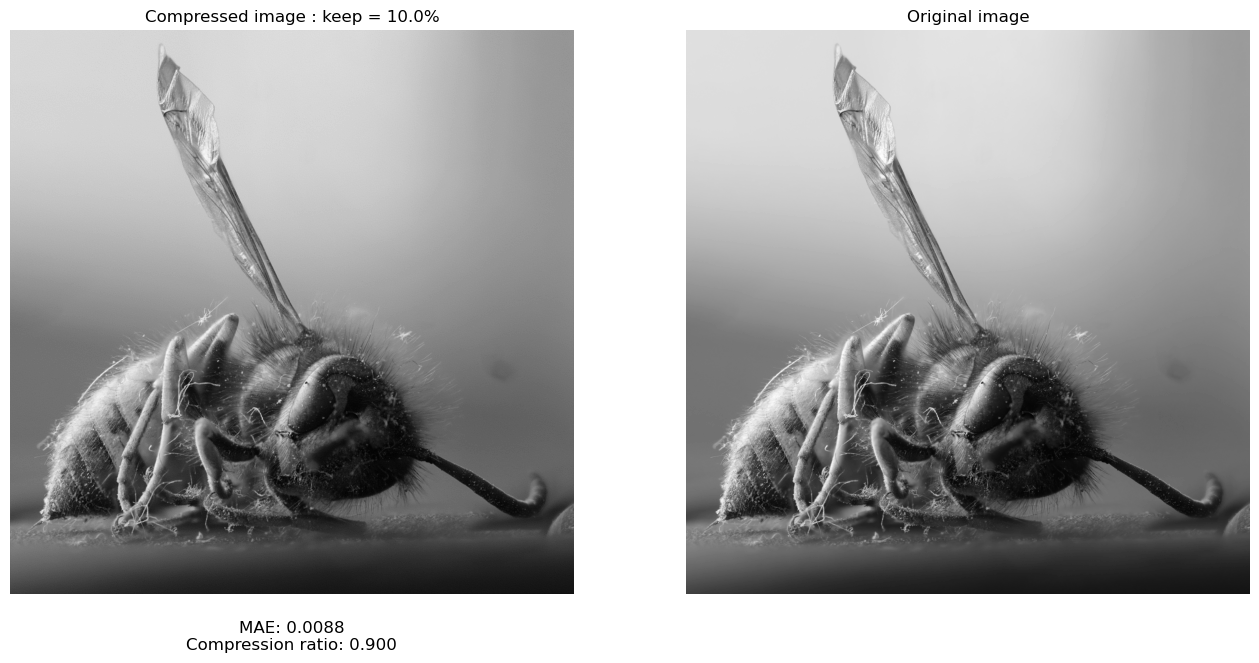

In [4]:

def compress_image_grayscale(image, keep):
   
    img_fft = fft2(image)
    img_fft_sorted = np.sort(np.abs(img_fft.flatten()))


    
    thresh = img_fft_sorted[int((1-keep)*len(img_fft_sorted))]
    img_fft_thresh = img_fft * (np.abs(img_fft) > thresh)
    img_thresh = np.abs(ifft2(img_fft_thresh))
    
    plt.figure(figsize=(16, 16))
    
    plt.subplot(1,2,1)
    plt.imshow(img_thresh, cmap='gray')
    plt.axis('off')
    plt.title(f'Compressed image : keep = {keep*100}%') 
    mae_value = mae(image, img_thresh)
    C = np.sum(np.abs(img_fft) <= thresh) / img_fft.size
    plt.text(0.5, -0.1, f"MAE: {mae_value:.4f}\nCompression ratio: {C:.3f}", fontsize=12, ha='center', transform=plt.gca().transAxes)
    
    plt.subplot(1,2,2)
    plt.imshow(image, cmap='gray')
    plt.axis('off') 
    plt.title('Original image')
    
    
        
        
compress_image_grayscale(wasp_grayscale, 0.1)

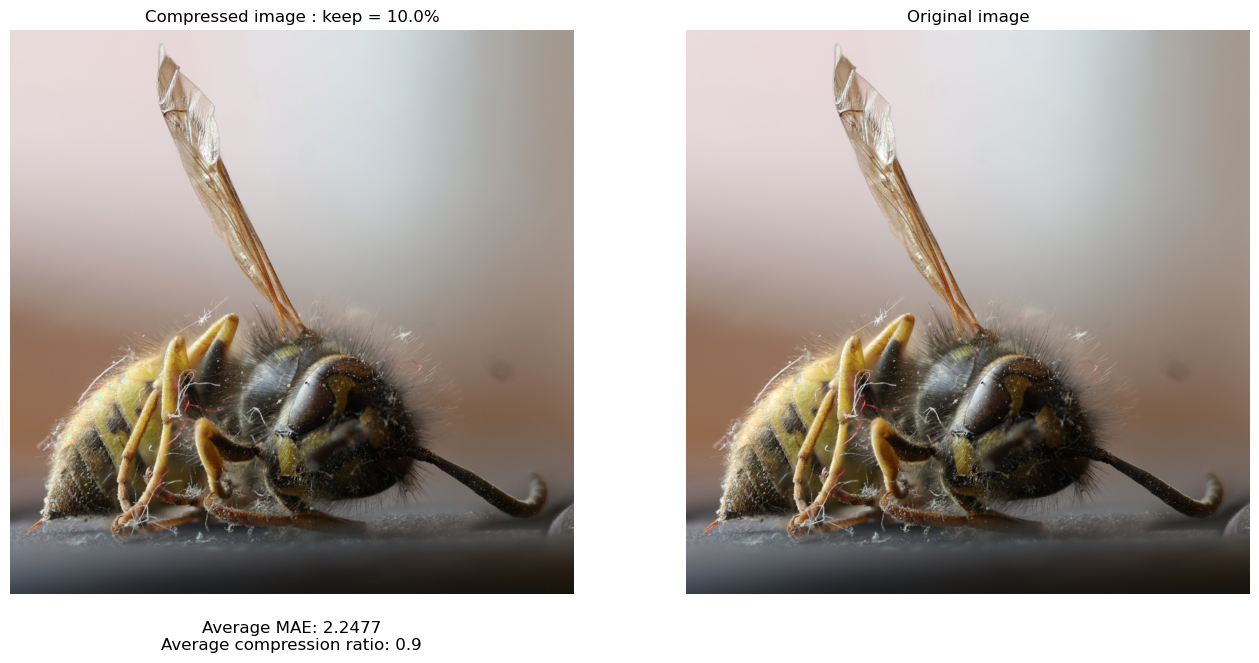

In [5]:

def compress_image_rgb(image, keep):
  
    compressed_channels = []
    mae_values = []
    C_values = []
    
    for channel in range(3):  
        channel_data = image[:, :, channel]
        channel_fft = fft2(channel_data)
        channel_fft_sorted = np.sort(np.abs(channel_fft.flatten()))

        thresh = channel_fft_sorted[int((1-keep)*len(channel_fft_sorted))]
        channel_fft_thresh = channel_fft * (np.abs(channel_fft) > thresh)
        channel_thresh = np.abs(ifft2(channel_fft_thresh))
        
        compressed_channels.append(channel_thresh)
        mae_values.append(mae(channel_data, channel_thresh))
        C_values.append(np.sum(np.abs(channel_fft) <= thresh) / channel_fft.size)
                        
    compressed_image = np.stack(compressed_channels, axis=-1)
    
    plt.figure(figsize=(16, 16))
    plt.subplot(1,2,1)
    plt.imshow(compressed_image.astype(np.uint8))
    plt.axis('off')
    plt.title(f'Compressed image : keep = {keep*100}%')
    average_mae = np.mean(mae_values)
    average_C = np.mean(C_values)
    plt.text(0.5, -0.1, f"Average MAE: {average_mae:.4f}\nAverage compression ratio: {average_C:.3}", fontsize=12, ha='center', transform=plt.gca().transAxes)
    
    plt.subplot(1,2,2)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original image')
    
    
compress_image_rgb(wasp_rgb, 0.1)


### Algorytm kompresji stratnej z użyciem transofrmacji falkowej

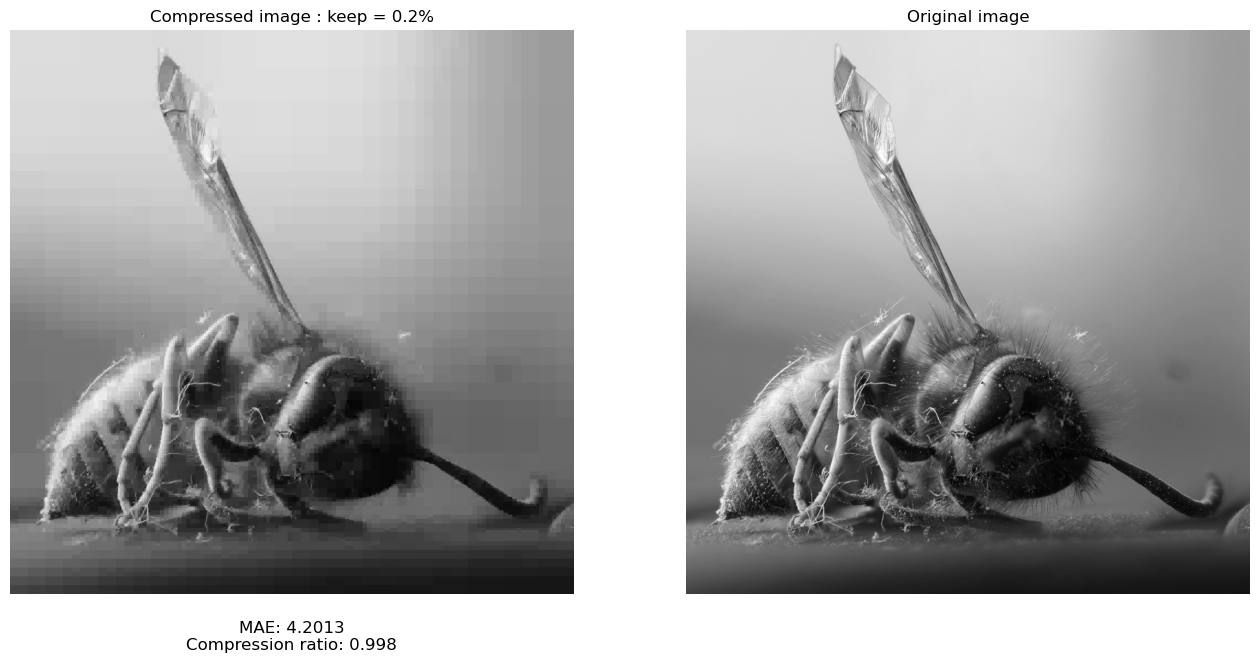

In [6]:

def wavelet_compression(image, keep, wavelet, level = 4):
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
        
    coeffs = pywt.wavedec2(image,wavelet,level)

    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

    coeff_sort = np.sort(np.abs(coeff_arr.flatten()))

    
    thresh = coeff_sort[int(np.floor((1-keep)*len(coeff_sort)))]
    coeff_thresh = np.abs(coeff_arr) > thresh
    coeff_filt = coeff_arr * coeff_thresh 
        
    coeffs_filt = pywt.array_to_coeffs(coeff_filt,coeff_slices,output_format='wavedec2')
    
    image_recon = pywt.waverec2(coeffs_filt,wavelet)
    image_recon = np.clip(image_recon, 0, 255)
    
    plt.figure(figsize=(16, 16))
    plt.subplot(1,2,1)
    plt.imshow(image_recon.astype(np.uint8), cmap='gray')
    plt.axis('off')
    plt.title(f'Compressed image : keep = {keep*100}%')
    mae_value = mae(image, image_recon)
    C = np.sum(np.abs(coeff_arr) <= thresh) / coeff_arr.size
    plt.text(0.5, -0.1, f"MAE: {mae_value:.4f}\nCompression ratio: {C:.3f}", fontsize=12, ha='center', transform=plt.gca().transAxes)
    
    plt.subplot(1,2,2)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title('Original image') 
    
wavelet_compression(wasp_grayscale, 0.002, wavelet='db1')
    

### Adaptacyjny algorytm doboru współczynnika kompresji

In [18]:
def compute_block_detail(block):
    """Oblicza istotność bloku na podstawie odchylenia standardowego (energii)."""
    return np.std(block)

def adaptive_compression_grayscale(image, block_size=8, detail_threshold=0.1):
    """
    Adaptacyjna kompresja obrazu w odcieniach szarości z wykorzystaniem FFT.
    
    Parameters:
    - image: obraz w odcieniach szarości (2D numpy array)
    - block_size: rozmiar bloku
    - detail_threshold: próg dla klasyfikacji bloków na szczegółowe / mniej szczegółowe
    
    Returns:
    - compressed_image: skompresowany obraz po rekonstrukcji
    """
    height, width = image.shape
    compressed_image = np.zeros_like(image, dtype=float)

    total_coefficients = 0
    kept_coefficients = 0
    
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i+block_size, j:j+block_size]
             
            detail = compute_block_detail(block)
            
            keep_ratio = 0.1 if detail > detail_threshold else 0.05
            
            block_fft = fft2(block)
            block_fft_sorted = np.sort(np.abs(block_fft.flatten()))
            
            thresh = block_fft_sorted[int((1-keep_ratio) * len(block_fft_sorted))]
            block_fft_thresh = block_fft * (np.abs(block_fft) > thresh)

            total_coefficients += block_fft.size
            kept_coefficients += np.sum(np.abs(block_fft) > thresh)
            
            block_recon = np.abs(ifft2(block_fft_thresh))
            
            compressed_image[i:i+block_size, j:j+block_size] = block_recon
    avg_compression_ratio = (kept_coefficients / total_coefficients) * 100
    compressed_image = np.clip(compressed_image, 0, 255)
    
    return compressed_image, avg_compression_ratio

Text(0.5, 1.0, 'Compression ratio: 4.630%')

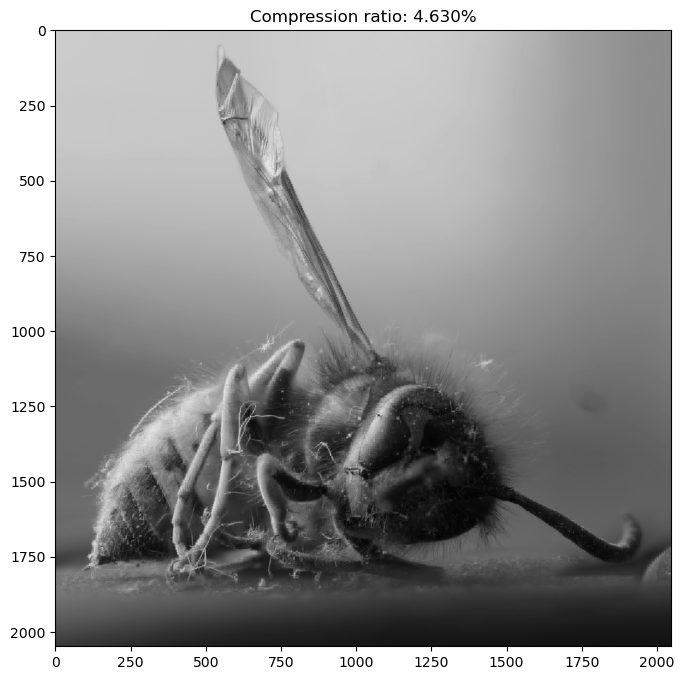

In [19]:
adaptivly_compressed_image = adaptive_compression_grayscale(wasp_grayscale)
plt.figure(figsize=(8, 8))
plt.imshow(adaptivly_compressed_image[0], cmap='gray')
plt.title(f"Compression ratio: {adaptivly_compressed_image[1]:.3f}%")

In [9]:
def compression_comparison(image, keep, wavelet):
    
    def compress_image_grayscale(image, keep):
   
        wasp_fft = fft2(image)
        wasp_fft_sorted = np.sort(np.abs(wasp_fft.flatten()))

        
        thresh = wasp_fft_sorted[int((1-keep)*len(wasp_fft_sorted))]
        wasp_fft_thresh = wasp_fft * (np.abs(wasp_fft) > thresh)
        wasp_thresh = np.abs(ifft2(wasp_fft_thresh))
        return wasp_thresh
    
    img_FFT_compressed = compress_image_grayscale(image, keep)
    
    def wavelet_compression(image, keep, wavelet, level = 4):
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        
        coeffs = pywt.wavedec2(image,wavelet,level)

        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

        coeff_sort = np.sort(np.abs(coeff_arr.flatten()))

        
        thresh = coeff_sort[int(np.floor((1-keep)*len(coeff_sort)))]
        coeff_thresh = np.abs(coeff_arr) > thresh
        coeff_filt = coeff_arr * coeff_thresh 
            
        coeffs_filt = pywt.array_to_coeffs(coeff_filt,coeff_slices,output_format='wavedec2')
        
        image_recon = pywt.waverec2(coeffs_filt,wavelet)
        image_recon = np.clip(image_recon, 0, 255)
        return image_recon
    
    img_wavelet_compressed = wavelet_compression(image, keep, wavelet)
    
    plt.figure(figsize=(16, 16))
    plt.subplot(1,2,1)
    plt.imshow(img_FFT_compressed, cmap='gray')
    plt.axis('off')
    plt.title(f'FFT compressed image : keep = {keep*100}%')

    
    plt.subplot(1,2,2)
    plt.imshow(img_wavelet_compressed, cmap='gray')
    plt.axis('off')
    plt.title(f'Wavelet compressed image : keep = {keep*100}%')

    


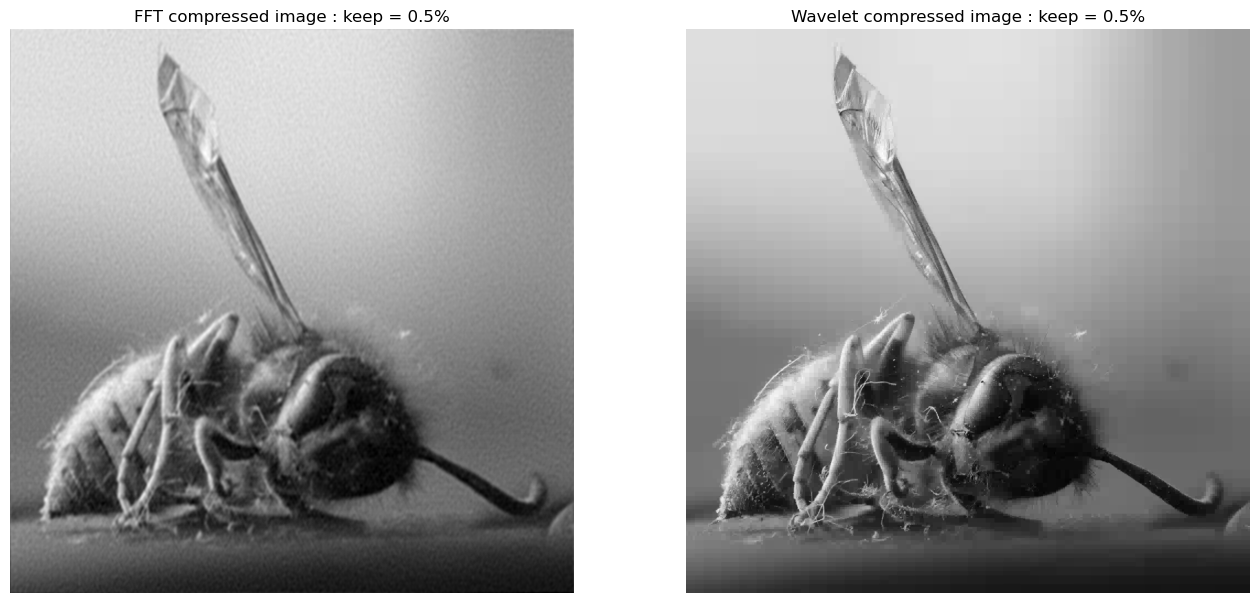

In [10]:
compression_comparison(wasp_grayscale, 0.005, wavelet='db1')